In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt
from matplotlib import animation

In [2]:
"""
This here is my playground to show that the generation of the particles are correct.
To explain meshgrid is a pain in the ass, I have started creating an explanation below but it might take awhile.
Essentially what happens is that meshgrid gives you all possible combinations of an x-dimension array.
However, it will generate it according to the axes respectively.
ie if i generate a 3d meshgrid it will give me x_array, y_array, z_array.
Transpose and reshape lets me merge all of them together so that i can have an array of particles sorted by x,y and z coordinates.
Its a bit hard to explain this so I may need help with the markdown part.
Or alternatively YuanZhe also suggested that we can purposely leave this vague to bait them for QNA.
"""

fill_lbound = np.linspace(30, 30,6)
fill_llimit = np.linspace(0,0,6)
fill_ulimit = np.linspace(40,40,6)
     
boundary_limit = np.linspace(0, 40, 6)
boundary_lbound =  np.linspace(30, 40, 6)
        
x_leftbound = np.array(np.meshgrid(fill_lbound, boundary_limit, boundary_limit)).T.reshape(-1,3)
x_leftbound = np.unique(x_leftbound, axis=0)
x_rightbound = np.array(np.meshgrid(fill_ulimit, boundary_limit, boundary_limit)).T.reshape(-1,3)
x_rightbound = np.unique(x_rightbound, axis=0)
x = np.append(x_leftbound, x_rightbound,axis=0)
        
y_leftbound = np.array(np.meshgrid(boundary_lbound, fill_llimit, boundary_limit)).T.reshape(-1,3)
y_leftbound = np.unique(y_leftbound, axis=0)
y_rightbound = np.array(np.meshgrid(boundary_lbound, fill_ulimit, boundary_limit)).T.reshape(-1,3)
y_rightbound = np.unique(y_rightbound, axis=0)
y = np.append(y_leftbound, y_rightbound,axis=0)
        
z_leftbound = np.array(np.meshgrid(boundary_lbound, boundary_limit, fill_llimit)).T.reshape(-1,3)
z_leftbound = np.unique(z_leftbound, axis=0)
z_rightbound = np.array(np.meshgrid(boundary_lbound, boundary_limit, fill_ulimit)).T.reshape(-1,3)
z_rightbound = np.unique(z_rightbound, axis=0)
z = np.append(z_leftbound, z_rightbound,axis=0)
        
#x

# IMPORTANT
Due to the nature of `meshgrid`, the creation of particles will be $n^3$
Note that `n` must be sufficiently large for neighboring particles to elicit a pressure effect on each other as well

In [3]:
class particle_array():
    """
    Updates
    I now have all my calculations occurring in particle_array
    I have no calculation methods in my individual particles.
    Calculations are now according to individual directions, ie along the x,y and z plane respectively.
    Refer to pairwise_better class for new calculations.
    For a nicer looking graph imo, I have restricted the x axis betweeen the lbound to the ulimit instead.
    
    Sorry, on time crunch here so I will keep things quite brief. Anything please message me, thank you!
    
    methods
    __init__
    Firstly, I establish my boundaries
    Next, I use meshgrid to form my particles (this will be at the top of the box)
    Then, I will create my boundary particles
    Once I am done, I will run the following sequence. This loop is permanent.
    Calculate density
    Calculate pressure
    Calculate acceleration
    Calculate Velocity
    This defines my preexisting conditions at time step 0.
    
    A bunch of get methods that was used in my own testing.
    
    A bunch of get methods that was used in my own testing.
    
    All calculations are the same as before with the exception of two: acceleration and pressure.
    These two calculations require the kernel, which takes into consideration the existence of my boundary particles.
    I will use this opportunity to explain what I have done with the boundary particles.
    
    I have two implementations, boundary 1 and boundary 2.
    Boundary #1 only takes into consideration the boundaries where it is primarily involved in. This means that boundary x 
    takes care of the x axis, etc.etc.
    
    Boundary #2 uses all boundary particles in each of the calculations. This should be the more "legit" version.
    I unfortunately do not have the time to look into it but something is causing my particles to be jumping at the 
    top of the box only. 
    
    I have offered the option of a multiplier effect, but I have not tried much on what happens when I create insanely
    high values on these.
    
    move. It works the same way, but I remove the elasticity.
    I still include my safety net when the particles cross the treshold, I will simply put them on
    the boundary itself.
    
    List of things that you could potentially play around with
    1. Pressure equation (I have left an additional copy of what definitely works below, which is commented.)
    2. The multiplier effect from boundary particles.
    
    """
    def __init__(self, n, dims, seed = 4):
        self.seed = random.seed(seed)
        self.lbound = dims[0] #This is my boundary for the xlimit too
        self.ubound = dims[1] #This is my boundary for the xlimit too
        self.llimit = dims[2] #These are my boundaries for the y and zlimit
        self.ulimit = dims[3] #These are my boundaries for the y and zlimit only
        particle_spacing = np.linspace(self.lbound, self.ubound, n, dtype = float)
#         particle_array = np.array(np.meshgrid(particle_spacing, particle_spacing, particle_spacing)).T.reshape(-1,3)
#         particle_array = np.unique(particle_array, axis = 0)
#         self.particles = [particle(coordinates, 
#                                    [0, 0, 0]) for coordinates in particle_array]
        
        pPositions = []
        for i in range(n**3):
            pPositions.append(
                [random.randrange(self.lbound, self.ubound),
                 random.randrange(self.lbound, self.ubound),
                 random.randrange(self.lbound, self.ubound)])
        self.particles = [particle(pPositions[i], [0, 0, 0]) for i in range(n**3)]
        
        """
        You thought it was over? Nah, welcome to generating boundary particles.
        x-axis will be looking at x=lbound and x=ulimit
        y-axis and z-axis will be looking at y OR z = llimit and y OR z = ulimit
        
        """
        filler_lbound = np.linspace(self.lbound, self.lbound,n)
        filler_llimit = np.linspace(self.llimit,self.llimit,n)
        filler_ulimit = np.linspace(self.ulimit,self.ulimit,n)
        
        boundary_spacing_limit = np.linspace(self.llimit, self.ulimit, n)
        boundary_spacing_lbound =  np.linspace(self.lbound, self.ulimit, n)
        
        boundary_x_leftbound = np.array(np.meshgrid(filler_lbound, boundary_spacing_limit, boundary_spacing_limit)).T.reshape(-1,3)
        boundary_x_leftbound = np.unique(boundary_x_leftbound, axis=0)
        boundary_x_rightbound = np.array(np.meshgrid(filler_ulimit, boundary_spacing_limit, boundary_spacing_limit)).T.reshape(-1,3)
        boundary_x_rightbound = np.unique(boundary_x_rightbound, axis=0)
        boundary_x = np.append(boundary_x_leftbound, boundary_x_rightbound,axis=0)
        
        boundary_y_leftbound = np.array(np.meshgrid(boundary_spacing_lbound, filler_llimit, boundary_spacing_limit)).T.reshape(-1,3)
        boundary_y_leftbound = np.unique(boundary_y_leftbound, axis=0)
        boundary_y_rightbound = np.array(np.meshgrid(boundary_spacing_lbound, filler_ulimit, boundary_spacing_limit)).T.reshape(-1,3)
        boundary_y_rightbound = np.unique(boundary_y_rightbound, axis=0)
        boundary_y = np.append(boundary_y_leftbound, boundary_y_rightbound,axis=0)
        
        boundary_z_leftbound = np.array(np.meshgrid(boundary_spacing_lbound, boundary_spacing_limit, filler_llimit)).T.reshape(-1,3)
        boundary_z_leftbound = np.unique(boundary_z_leftbound, axis=0)
        boundary_z_rightbound = np.array(np.meshgrid(boundary_spacing_lbound, boundary_spacing_limit, filler_ulimit)).T.reshape(-1,3)
        boundary_z_rightbound = np.unique(boundary_z_rightbound, axis=0)
        boundary_z = np.append(boundary_z_leftbound, boundary_z_rightbound,axis=0)
        
        self.xbound = [boundary_particle(coordinates) for coordinates in boundary_x]
        self.ybound = [boundary_particle(coordinates) for coordinates in boundary_y]
        self.zbound = [boundary_particle(coordinates) for coordinates in boundary_z]
        self.allbound = np.append(self.xbound, self.ybound,axis=0)
        self.allbound = np.append(self.allbound, self.zbound,axis=0)
        
        """
        Now with all these new boundary tings, we finalize the parameters for our particle.
        """
        
        self.calc_density()
        self.calc_pressure()
        self.calc_accel()
        self.calc_veloc()
    
    def get_boundary_x(self):
        for particle in self.xbound:
            print(particle.p)
    def get_boundary_y(self):
        for particle in self.ybound:
            print(particle.p)
    def get_boundary_z(self):
        for particle in self.zbound:
            print(particle.p)
            
    def get_specific_pos(self, n):
        return self.particles[n].p
    def get_position(self):
        for particle in self.particles:
            print(particle.p)
            
    def get_specific_direction(self,n):
        return self.particles[n].d
    def get_direction(self):
        for particle in self.particles:
            print(particle.d)
            
    def get_initrho(self):
        for particle in self.particles:
            print(particle.initrho)
    def get_initpre(self):
        for particle in self.particles:
            print(particle.initpre)
    def get_rho(self):
        for particle in self.particles:
            print(particle.rho)
            
    def get_specific_pressure(self, n):
        return self.particles[n].pre
    def get_pre(self):
        for particle in self.particles:
            print(particle.pre)
            
    def get_specific_accel(self, n):
        return self.particles[n].a
    def get_accel(self):
        for particle in self.particles:
            print(particle.a)
    def get_veloc(self):
        for particle in self.particles:
            print(particle.d)
            
    def calc_accel(self):
        for particle_1 in self.particles:
            temporary = np.array([0, 0, 0], dtype = float)
            for particle_2 in self.particles:
                if id(particle_1) != id(particle_2):
                    temporary += (particle_2.m)*\
                    ((particle_1.pre / (particle_1.rho ** 2)) + (particle_2.pre / (particle_2.rho ** 2))) *\
                    (pairwise_better(particle_1, particle_2).dgaus_kern())
            particle_1.a = -1 * temporary
            
        """
        Boundary attempt #1
        """
        for particle_1 in self.particles:
            for i in range(3):
                boundary_effect = 0
                if i == 0:
                    for bound_particle in self.xbound:
                        boundary_effect += (bound_particle.m)*\
                    ((particle_1.pre[i] / (particle_1.rho[i] ** 2)) + (bound_particle.pre[i] / (bound_particle.initrho[i] ** 2))) *\
                    (pairwise_better(particle_1, bound_particle).dgaus_kern()[i])
                    particle_1.a[i] -= float(4 * boundary_effect)
                elif i == 1:
                    for bound_particle in self.ybound:
                        boundary_effect += (bound_particle.m)*\
                    ((particle_1.pre[i] / (particle_1.rho[i] ** 2)) + (bound_particle.pre[i] / (bound_particle.initrho[i] ** 2))) *\
                    (pairwise_better(particle_1, bound_particle).dgaus_kern()[i])
                    particle_1.a[i] -= float(4 * boundary_effect)
                else:
                    for bound_particle in self.zbound:
                        boundary_effect += (bound_particle.m)*\
                    ((particle_1.pre[i] / (particle_1.rho[i] ** 2)) + (bound_particle.pre[i] / (bound_particle.initrho[i] ** 2))) *\
                    (pairwise_better(particle_1, bound_particle).dgaus_kern()[i])
                    particle_1.a[i] -= float(4 * boundary_effect)

#         """
#         Boundary attempt #2
#         """
#         for particle_1 in self.particles:
#             temporary = np.array([0, 0, 0], dtype = float)
#             for bound_particle in self.allbound:
#                 temporary += (bound_particle.m)*\
#                     ((particle_1.pre / (particle_1.rho ** 2)) + (bound_particle.pre / (bound_particle.initrho ** 2))) *\
#                     (pairwise_better(particle_1, bound_particle).dgaus_kern())
#             particle_1.a -= 2 * temporary
                
            
    def calc_veloc(self):
        for particle in self.particles:
            for i in range(3):
                if i == 2:
                    potential_speed = (particle.dt * particle.a[i]) - (particle.dt * particle.g)
                    if potential_speed + particle.d[i] > particle.vmax:
                        particle.d[i] = particle.vmax
                    elif potential_speed + particle.d[i] < -particle.vmax:
                        particle.d[i] = -particle.vmax
                    else:
                        particle.d[i] += potential_speed
                else:
                    potential_speed = (particle.dt * particle.a[i])
                    if potential_speed + particle.d[i] > particle.vmax:
                        particle.d[i] = particle.vmax
                    elif potential_speed + particle.d[i] < -particle.vmax:
                        particle.d[i] = -particle.vmax
                    else:
                        particle.d[i] += potential_speed
                        
    def move(self):
        for particle in self.particles:
            potential_positions = particle.p.copy()
            for i in range(3):
                potential_positions[i] += particle.d[i] * particle.dt
                if i == 0:
                    if potential_positions[i] < self.lbound:
                        potential_positions[i] = self.lbound
                        #particle.d[i] *= -1
                    elif potential_positions[i] > self.ulimit:
                        potential_positions[i] = self.ulimit
                        #particle.d[i] *= -1
                else:
                    if potential_positions[i] < self.llimit:
                        potential_positions[i] = self.llimit
                        #particle.d[i] *= -1
                    elif potential_positions[i] > self.ulimit:
                        potential_positions[i] = self.ulimit
                        #particle.d[i] *= -1
                particle.p = potential_positions


    def calc_density(self):
        for particle_1 in self.particles:
            temporary = np.array([0,0,0], dtype = float)
            for particle_2 in self.particles:
                if id(particle_1) != id(particle_2):
                    temporary += particle_2.m * pairwise_better(particle_1, particle_2).gaus_kern()
                particle_1.rho = temporary
        
        """
        Boundary attempt
        """
        for particle_1 in self.particles:
            for i in range(3):
                boundary_effect = 0
                if i == 0:
                    for bound_particle in self.xbound:
                        boundary_effect += pairwise_better(particle_1, bound_particle).gaus_kern()[i]
                    particle_1.rho[i] += float(1 * boundary_effect)
                elif i == 1:
                    for bound_particle in self.ybound:
                        boundary_effect += pairwise_better(particle_1, bound_particle).gaus_kern()[i]
                    particle_1.rho[i] += float(1 * boundary_effect)
                else:
                    for bound_particle in self.zbound:
                        boundary_effect += pairwise_better(particle_1, bound_particle).gaus_kern()[i]
                    particle_1.rho[i] += float(1 * boundary_effect)
                    
#         """
#         Boundary attempt #2
#         """
#         for particle_1 in self.particles:
#             temporary = np.array([0,0,0], dtype = float)
#             for bound_particle in self.allbound:
#                 temporary += particle_2.m * pairwise_better(particle_1, particle_2).gaus_kern()
#             particle_1.rho += 2* temporary
                
    def calc_pressure(self):
        for particle in self.particles:
            particle.pre = (((0.01**2) * 1)/7) * ((particle.rho / 1)**7 - 1)    
            #particle.pre = (((0.01**2) * 1)/7) * ((particle.rho / 1)**7 - 1)    # i dont rmb what i did but i played with the values here

In [4]:
class particle():
    def __init__(self, position, direction):
        """
        The most important value here is self.dt. This has been optimized for the current animation that I am generating.
        The other iterations that I have tried all results in shitty animations due to the position of the particles that 
        are being calculated. 
        """
        self.p = position
        self.d = direction
        self.m = 1
        self.dt = 0.25 #s
        self.initrho = 1
        self.rho = 0
        self.pre = 0
        self.vmax = 10
        self.a = 0
        self.g = 9.81
    
    def get_magnitude(self):
        x, y, z = self.p
        return ((x**2) + (y**2) + (z**2))**(1/2)
        #return np.linalg.norm(self.p) This one works too

In [5]:
class boundary_particle():
    def __init__(self, position):
        """
        These are my boundary particles.
        I created this in the event that we are interested in further optimisation. We can create one big array of particles,
        and if we find a mulltiplier that is ideal, we just need to check the type of particle to elicit the multiplier effect.
        """
        self.p = position
        self.m = 1
        self.initrho = np.array([1,1,1])
        self.pre = np.array([(((0.01**2) * 1)/7) * ((1 / 1)**7 - 1),(((0.01**2) * 1)/7) * ((1 / 1)**7 - 1),(((0.01**2) * 1)/7) * ((1 / 1)**7 - 1)])

    
    def get_magnitude(self):
        x, y, z = self.p
        return ((x**2) + (y**2) + (z**2))**(1/2)
        #return np.linalg.norm(self.p) This one works too

In [6]:
class pairwise_calculator():
    """
    The previous pairwise calculator that I have used. Kept here for reference
    """
    def __init__(self, particle1, particle2):
        self.p1 = particle1
        self.p2 = particle2
        
    def gaus_kern(self, h = 1, d = 3):
        mag_1 = self.p1.get_magnitude()
        mag_2 = self.p2.get_magnitude()
        delta_mag = mag_1 - mag_2
        return ((1 / h*(np.pi**(1/2)))**d) * (np.e**(-(delta_mag**2) / (h**2)))
    
    def dgaus_kern(self, h = 1, d = 3):
        mag_1 = self.p1.get_magnitude()
        mag_2 = self.p2.get_magnitude()
        delta_mag = mag_1 - mag_2
        return -((2*np.e**(-(delta_mag**2) / (h**2)))*(delta_mag)) / ((h**5)*(np.pi*(3/2)))

In [7]:
class pairwise_better():
    """
    The current pairwise calculator that I am using.
    This calculates x,y and z individually. Whether it has a huge change I honestly do not know lmao.
    """
    def __init__(self, particle1, particle2):
        self.p1 = particle1
        self.p2 = particle2
    
    def gaus_kern(self, h = 1, d = 1):
        temporary_list = []
        for i,j in zip(self.p1.p, self.p2.p):
            temporary_list.append(((1 / h*(np.pi**(1/2)))**d) * (np.e**(-((i-j)**2) / (h**2))))
        return np.array(temporary_list, dtype = float)
    
    def dgaus_kern(self, h = 1, d=1):
        temporary_list = []
        for i,j in zip(self.p1.p, self.p2.p):
            temporary_list.append(-((2*np.e**(-((i-j)**2) / (h**2)))*(i-j)) / ((h**(2+d))*(np.pi*(d/2))))
        return np.array(temporary_list, dtype = float)

In [8]:
"""
Quick testing ground just to make sure any new code implemented can actually run smoothly.
Can also use this to look see each time step what happens.
"""

my_particles = particle_array(3, [10, 20, 0, 20])
#print(my_particles.get_boundary_x())

#for i in range(50):
    #print("position = " + str(my_particles.get_specific_pos(0)))
    #print("velocity = " + str(my_particles.get_specific_direction(0)))
    #print("acc = " + str(my_particles.get_specific_accel(0)))
    #print("pressure = " + str(my_particles.get_specific_pressure(0)))
    #my_particles.move()
    #my_particles.calc_density()
    #my_particles.calc_pressure()
    #my_particles.calc_accel()
    #my_particles.calc_veloc()

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation

"""
This is where I create all my data and store them in a table. This allows me to call each data timepoint much faster,
allowing for a smoother animation.
Do take note that the duration and dt here are dummy variables. It is just meant for me to plot 100 points.
They are not related in any way to the dt used in class particle.
"""

#Creation of my particle
plot_particles = particle_array(n=7, dims=[70, 80, 0, 80])
duration = 1
dt = 0.01
table = {}
def memoize():
    global table, duration, dt
    step = 0
    while step <=duration:
        plot_particles.move()
        plot_particles.calc_density()
        plot_particles.calc_pressure()
        plot_particles.calc_accel()
        plot_particles.calc_veloc()
        temp = []
        for particle in plot_particles.particles:
            temp.append(list(particle.p))
        table[step] = temp
        step += dt
    return table
x= memoize()
print("complete")

complete


What you would actually observe below is a few things
1. The particles inbetween are bouncing at the speed of light, there is no irregularity. Unfortunately, trying to use a random generator does not seem to be much better either. 
2. Particles are literally bouncing on top of one another which is quite funny.

<IPython.core.display.Javascript object>


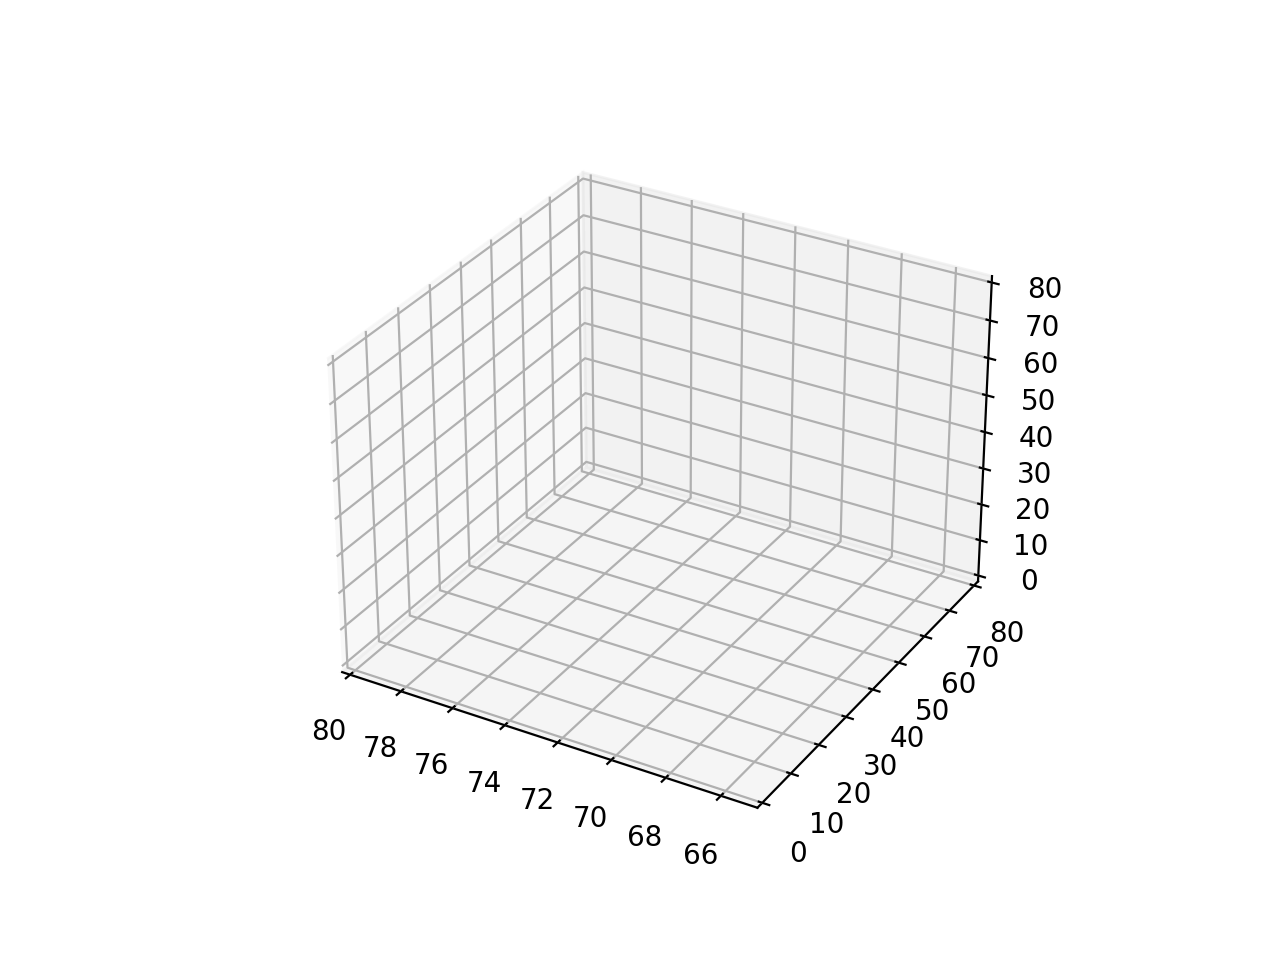

In [11]:
%matplotlib notebook
##############################################################
#The creation of my figure                                   #
fig = plt.figure()                                           #
ax = fig.add_subplot(111, projection='3d')                   #
#Creating a global variable scat to store particle positions #
scat = ax.scatter([], [], [])                                #
##############################################################

my_timer = 0
dt = 0.01

def init():
    """
    Creates my starting particle positions on the graph
    """
    ax.clear()
    ax.set_xlim3d([65, 80])
    ax.invert_xaxis()
    ax.set_ylim3d([0, 80])
    ax.set_zlim3d([0, 80])
    scat = ax.scatter(
        [particle[0] for particle in table[my_timer]],
        [particle[1] for particle in table[my_timer]],
        [particle[2] for particle in table[my_timer]]
    )
    return scat,


def animate(frame):
    global my_timer, dt
        
    scat._offsets3d = (
        [particle[0] for particle in table[my_timer]],
        [particle[1] for particle in table[my_timer]],
        [particle[2] for particle in table[my_timer]]
    )
    my_timer += dt
    return scat,

#Interval here delays the time per frame shown
ani = FuncAnimation(fig, animate, frames=duration, init_func=init, blit=False, interval = 120)
plt.show()

# What needs to be done?
## Making things look more readable
## Creating noise in the system
## Application of dampening force? (I did not manage to get to this unfortunately)
## Optimization (under chatgpt?)

How does `np.meshgrid` work?  
`np.meshgrid` takes in n number of lists and returns an $n^n$ array  
For example:
```python
points = np.linspace(0, 10, 3) #Generates 4 evenly spaced particles from 0 to 10
np.array(np.meshgrid(points,points,, points indexing = 'ij'))
```
The output of that would be a list of 3 arrays
```python
array([[[ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.]],
 
        [[ 5.,  5.,  5.],
         [ 5.,  5.,  5.],
         [ 5.,  5.,  5.]],
 
        [[10., 10., 10.],
         [10., 10., 10.],
         [10., 10., 10.]]])
```
As you can see, this is a far cry away from achieving all possible permutations. 

